In [1]:
import pandas as pd
import numpy as np

In [65]:
BONING_PATHS = [
    'Theme2/P1/Boning/MVN-J-Boning-64-001.xlsx', 
    'Theme2/P1/Boning/MVN-J-Boning-90-003.xlsx', 
    'Theme2/P1/Boning/MVN-J-Boning-90-002.xlsx', 
    'Theme2/P1/Boning/MVN-J-Boning-90-004.xlsx', 
    'Theme2/P1/Boning/MVN-J-Boning-64-006.xlsx', 
    'Theme2/P1/Boning/MVN-J-Boning-64-004.xlsx', 
    'Theme2/P1/Boning/MVN-J-Boning-64-002.xlsx', 
    'Theme2/P1/Boning/MVN-J-Boning-90-001.xlsx', 
    'Theme2/P1/Boning/MVN-J-Boning-64-003.xlsx', 
    'Theme2/P1/Boning/MVN-J-Boning-79-001.xlsx', 
    'Theme2/P1/Boning/MVN-J-Boning-64-005.xlsx',
    'Theme2/P2/Boning/MVN-S-Boning-89-001.xlsx', 
    'Theme2/P2/Boning/MVN-S-Boning-89-002.xlsx', 
    'Theme2/P2/Boning/MVN-S-Boning-89-003.xlsx', 
    'Theme2/P2/Boning/MVN-S-Boning-76-001.xlsx', 
    'Theme2/P2/Boning/MVN-S-Boning-63-003.xlsx', 
    'Theme2/P2/Boning/MVN-S-Boning-63-001.xlsx', 
    'Theme2/P2/Boning/MVN-S-Boning-76-002.xlsx', 
    'Theme2/P2/Boning/MVN-S-Boning-63-002.xlsx', 
    'Theme2/P2/Boning/MVN-S-Boning-89-004.xlsx'
]

SLICING_PATHS = [
    'Theme2/P1/Slicing/MVN-J-Slicing-64-001.xlsx', 
    'Theme2/P1/Slicing/MVN-J-Slicing-87-001.xlsx', 
    'Theme2/P1/Slicing/MVN-J-Slicing-73-001.xlsx',
    'Theme2/P2/Slicing/MVN-S-Slicing-87-001.xlsx', 
    'Theme2/P2/Slicing/MVN-S-Slicing-73-001.xlsx', 
    'Theme2/P2/Slicing/MVN-S-Slicing-63-001.xlsx'
]

ACCELERATION_SHEETS = [
    'Segment Acceleration', 
    'Segment Angular Acceleration'
]

boning_activity_class_names = ['Idle', 'Walking', 'Steeling', 'Reaching', 'Cutting', 'Dropping']
slicing_activity_class_names = ['Idle', 'Walking', 'Steeling', 'Reaching', 'Cutting', 'Slicing', 'Pulling', 'Placing/Manipulation', 'Dropping']

# **Merging the Files into a DataFrame**

- merge boning and slicing separately

In [3]:
# from collections import defaultdict

# sharpness_levels = [64, 79, 90, 87, 73, 63, 76, 89]

# def process_acceleration_data(file_paths, sharpness_levels):
#     """Process acceleration data from multiple Excel files with different sharpness levels."""
#     # Dictionary to store processed data by sheet type
#     sheet_data = defaultdict(list)
    
#     # Process all files and extract data by sheet type
#     for file_path, sharpness in zip(file_paths, sharpness_levels):
#         try:
#             xls = pd.ExcelFile(file_path)
            
#             for sheet_name in xls.sheet_names:
#                 if sheet_name not in ACCELERATION_SHEETS:
#                     continue
                
#                 try:
#                     # Read the sheet
#                     df = pd.read_excel(xls, sheet_name=sheet_name)
#                     print(f"{df.shape}")
                    
#                     if df.empty:
#                         continue

#                     if 'Label' not in df.columns:
#                         print(f"Skipping {sheet_name} since it doesn't have a label column")
#                         continue
                    
#                     # Add sharpness column
#                     df['sharpness'] = sharpness
                    
#                     # Add sheet name as a column to differentiate data source
#                     df['sheet_type'] = sheet_name
                    
#                     # Add to our collection
#                     sheet_data[sheet_name].append(df)
                
#                 except Exception as e:
#                     print(f"Error processing sheet {file_path} {sheet_name}: {e}")
        
#         except Exception as e:
#             print(f"Error processing file {file_path}: {e}")
    
#     # Combine data from all files
#     combined_dfs = []
    
#     for sheet_name, dfs in sheet_data.items():
#         if dfs:
#             # Concatenate all data for this sheet type
#             sheet_combined_df = pd.concat(dfs, ignore_index=True)
#             combined_dfs.append(sheet_combined_df)
    
#     # Return combined data frame
#     if combined_dfs:
#         final_df = pd.concat(combined_dfs, ignore_index=True)
#         return final_df
    
#     return None

# def main():
#     # Process the data
#     merged_df = process_acceleration_data(
#         file_paths=SLICING_PATHS,
#         sharpness_levels=sharpness_levels
#     )
    
#     if merged_df is None or merged_df.empty:
#         print("No results generated!")
#         return
    
#     # Save the final merged dataframe
#     output_file = "slicing_acceleration_data.csv"
#     merged_df.to_csv(output_file, index=False)
#     print(f"Saved data to {output_file} ({merged_df.shape[0]} rows, {merged_df.shape[1]} columns)")

# if __name__ == "__main__":
#     main()

In [4]:
boning_df = pd.read_csv('boning_acceleration_data.csv')
slicing_df = pd.read_csv('slicing_acceleration_data.csv')

# **Creating composite features based off XYZ**

In [5]:
def create_composite_features(df):
    """
    Create composite features from motion capture data - optimized for performance
    """
    # Columns to preserve
    preserved_columns = {}
    if 'Label' in df.columns:
        preserved_columns['Label'] = df['Label']
    if 'sharpness' in df.columns:
        preserved_columns['sharpness'] = df['sharpness']
    
    # Get all unique body parts
    body_parts = set()
    for col in df.columns:
        if col.endswith(' x') or col.endswith(' y') or col.endswith(' z'):
            body_part = col[:-2]  # Remove the ' x', ' y', or ' z' suffix
            body_parts.add(body_part)
    
    # Dictionary to collect all features
    all_features = {}
    
    # Create aggregated features for each body part
    for body_part in body_parts:
        # Extract x, y, z components
        x_col = f"{body_part} x"
        y_col = f"{body_part} y"
        z_col = f"{body_part} z"
        
        # Skip if any component is missing
        if not (x_col in df.columns and y_col in df.columns and z_col in df.columns):
            continue
        
        # RMS of x and y ("mean")
        all_features[f"{body_part}_mean"] = np.sqrt((df[x_col]**2 + df[y_col]**2) / 2)
        
        # RMS of y and z ("standard deviation")
        all_features[f"{body_part}_std"] = np.sqrt((df[y_col]**2 + df[z_col]**2) / 2)
        
        # RMS of z and x ("min")
        all_features[f"{body_part}_min"] = np.sqrt((df[z_col]**2 + df[x_col]**2) / 2)
        
        # RMS of x, y, and z ("max")
        all_features[f"{body_part}_max"] = np.sqrt((df[x_col]**2 + df[y_col]**2 + df[z_col]**2) / 3)
        
        # roll calculation ("Area under the curve")
        denominator = np.sqrt(df[x_col]**2 + df[z_col]**2)
        denominator = np.where(denominator == 0, 1e-10, denominator)
        all_features[f"{body_part}_AUC"] = 180 * np.arctan2(df[y_col], denominator) / np.pi
        
        # pitch calculation ("peaks")
        denominator = np.sqrt(df[y_col]**2 + df[z_col]**2)
        denominator = np.where(denominator == 0, 1e-10, denominator)
        all_features[f"{body_part}_peaks"] = 180 * np.arctan2(df[x_col], denominator) / np.pi
    
    # Combine preserved columns and features
    all_features.update(preserved_columns)
    
    # Create DataFrame in one go
    aggregated_features = pd.DataFrame(all_features)
    
    return aggregated_features

In [6]:
boning_df = create_composite_features(boning_df)
slicing_df = create_composite_features(slicing_df)

In [7]:
print(slicing_df.shape)
print(boning_df.shape)

(357114, 140)
(151158, 140)


In [8]:
slicing_df['Label'].unique()

array([ 0.,  4.,  8.,  2.,  1.,  3.,  5., nan,  7.,  6.])

#### Converting the label values into int

In [9]:
slicing_df.dropna(inplace=True)
slicing_df['Label'] = slicing_df['Label'].round().astype(int)

In [10]:
boning_df['sharpness'].unique()

array([64, 90, 87, 73, 63, 76, 89, 79])

# **Implementing an Over and Under sampling pipeline**

In [11]:
import numpy as np
import pandas as pd
import tensorflow as tf
from collections import Counter

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

from imblearn.under_sampling import TomekLinks
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTENC

def oversample_data(df):
    # 1. Split off train / (val+test)
    train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['Label'], random_state=42)
    
    # 2. Further split val + test 50/50
    val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['Label'], random_state=42)
    
    # 3. Prepare X and combined target
    numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
    X = train_df[numeric_cols].copy()
    y_combined = (X['Label'].astype(str) + "_" + X['sharpness'].astype(str)).values
    X = X.drop(columns=['sharpness'])
    
    # 4. Scale numeric features
    numeric_feats = [c for c in X.columns if c != 'Label']
    scaler = RobustScaler()
    X[numeric_feats] = scaler.fit_transform(X[numeric_feats])
    
    # 5. Build sampling strategy
    counts = Counter(y_combined)
    majority = max(counts.values())
    target_smote = int(0.5 * majority)
    smote_strategy = {cls: target_smote for cls, cnt in counts.items() if cnt < target_smote}
    
    # 6. Set up SMOTENC + Tomek pipeline
    categorical_features = [X.columns.get_loc('Label')]
    smote_nc = SMOTENC(categorical_features=categorical_features,
                       random_state=42, k_neighbors=15,
                       sampling_strategy=smote_strategy)
    tomek = TomekLinks(sampling_strategy='all')
    pipeline = ImbPipeline([('smote', smote_nc),
                            ('undersample', tomek)])
    
    # 7. Run oversampling
    X_resampled, y_resampled = pipeline.fit_resample(X.values, y_combined)
    
    # 8. Extract just the activity label (before the underscore)
    y_activity = np.array([int(lbl.split('_')[0]) for lbl in y_resampled])
    
    # 9. Build final balanced DataFrame
    balanced_df = pd.DataFrame(X_resampled, columns=X.columns)
    balanced_df['Label'] = y_activity
    
    print("Balanced class counts:", Counter(balanced_df['Label']))
    return balanced_df, y_resampled


In [12]:
slicing_df_resampled, slicing_df_target = oversample_data(slicing_df)

Balanced class counts: Counter({4: 114565, 5: 81699, 0: 75300, 2: 75252, 3: 75233, 8: 75160, 7: 56412, 6: 56382, 1: 37676})


In [13]:
boning_df_resampled, boning_df_target= oversample_data(boning_df)

Balanced class counts: Counter({4: 88331, 0: 77213, 3: 77205, 2: 77205, 5: 67564, 1: 67533})


In [14]:
slicing_df_resampled

,Left Upper Leg_mean,Left Upper Leg_std,Left Upper Leg_min,Left Upper Leg_max,Left Upper Leg_AUC,Left Upper Leg_peaks,Left Toe_mean,Left Toe_std,Left Toe_min,Left Toe_max,...,Right Lower Leg_max,Right Lower Leg_AUC,Right Lower Leg_peaks,L5_mean,L5_std,L5_min,L5_max,L5_AUC,L5_peaks,Label
0,0.284726,-0.231925,0.089892,-0.018087,0.035955,-1.569853,0.047720,-0.157000,0.213577,-0.002160,...,-0.297593,1.530643,-0.151742,0.238543,0.122807,-0.218940,0.031058,1.295670,0.262590,5
1,-0.109006,-0.103915,-0.233245,-0.181927,1.476828,-0.402963,-0.223970,-0.177675,-0.335358,-0.273601,...,-0.361415,1.539473,-0.047313,-0.271340,-0.233728,-0.291369,-0.279375,-1.187374,0.202672,4
2,0.646308,-0.188521,0.225204,0.120314,-0.221487,-1.549615,-0.211195,-0.155094,-0.146806,-0.213513,...,2.969601,-1.529203,-0.119420,0.439211,0.636763,0.642914,0.519732,-0.445492,0.443139,4
3,-0.182241,-0.229628,-0.133951,-0.210490,0.589330,1.272732,-0.301699,-0.455739,-0.177327,-0.329747,...,-0.379448,1.049589,0.723446,0.177510,0.078982,-0.032256,0.026821,-0.869545,-0.516760,3
4,-0.605534,-0.279872,-0.266250,-0.355731,-0.528122,0.486907,-0.308564,-0.236839,-0.433840,-0.343387,...,-0.273899,-1.329104,-0.489319,-0.323960,-0.181090,-0.174119,-0.235962,-0.405122,0.059666,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647674,0.308058,0.235534,0.311056,0.223663,0.195181,0.680874,-0.169445,-0.195355,-0.017156,-0.155756,...,0.162290,-0.003999,0.339099,0.539903,0.632829,0.576673,0.516949,-0.544717,0.407352,8
647675,-0.220607,-0.171947,-0.194995,-0.222728,-1.098756,-0.715022,0.081681,-0.120939,0.256416,0.041436,...,-0.284679,-1.645514,-0.032064,-0.275846,-0.261270,-0.227304,-0.273945,-0.568679,-0.275945,8
647676,0.772762,2.349450,2.259739,2.127046,0.012713,-0.125224,0.242933,0.879450,1.185523,0.760718,...,0.489713,-0.016629,0.613186,1.301221,1.017351,0.402458,0.820090,0.991908,0.299131,8
647677,0.876826,0.741835,0.837264,0.737750,-0.019240,0.580315,-0.156253,0.635108,0.647587,0.418157,...,0.728343,0.389096,-0.131148,0.170337,0.077643,-0.099286,0.012567,-0.975522,-0.435685,8


In [15]:
sharpness_resampled = np.array([int(lbl.split('_')[1]) for lbl in boning_df_target])
boning_df_resampled['sharpness'] = sharpness_resampled

print("Now balanced_df columns:", boning_df_resampled.columns)

Now balanced_df columns: Index(['Left Upper Leg_mean', 'Left Upper Leg_std', 'Left Upper Leg_min',
       'Left Upper Leg_max', 'Left Upper Leg_AUC', 'Left Upper Leg_peaks',
       'Left Toe_mean', 'Left Toe_std', 'Left Toe_min', 'Left Toe_max',
       ...
       'Right Lower Leg_AUC', 'Right Lower Leg_peaks', 'L5_mean', 'L5_std',
       'L5_min', 'L5_max', 'L5_AUC', 'L5_peaks', 'Label', 'sharpness'],
      dtype='object', length=140)


In [16]:
sharpness_resampled = np.array([int(lbl.split('_')[1]) for lbl in slicing_df_target])
slicing_df_resampled['sharpness'] = sharpness_resampled

print("Now balanced_df columns:", slicing_df_resampled.columns)

Now balanced_df columns: Index(['Left Upper Leg_mean', 'Left Upper Leg_std', 'Left Upper Leg_min',
       'Left Upper Leg_max', 'Left Upper Leg_AUC', 'Left Upper Leg_peaks',
       'Left Toe_mean', 'Left Toe_std', 'Left Toe_min', 'Left Toe_max',
       ...
       'Right Lower Leg_AUC', 'Right Lower Leg_peaks', 'L5_mean', 'L5_std',
       'L5_min', 'L5_max', 'L5_AUC', 'L5_peaks', 'Label', 'sharpness'],
      dtype='object', length=140)


In [17]:
boning_df_resampled.head()

,Left Upper Leg_mean,Left Upper Leg_std,Left Upper Leg_min,Left Upper Leg_max,Left Upper Leg_AUC,Left Upper Leg_peaks,Left Toe_mean,Left Toe_std,Left Toe_min,Left Toe_max,...,Right Lower Leg_AUC,Right Lower Leg_peaks,L5_mean,L5_std,L5_min,L5_max,L5_AUC,L5_peaks,Label,sharpness
0,0.682552,1.868107,1.921719,1.677740,0.101988,-0.297216,-0.047873,0.385706,0.229716,0.157003,...,0.186578,-1.366432,0.508721,1.260089,1.065460,0.951332,0.466713,0.164970,4,87
1,1.505051,1.855258,1.910049,1.724229,-0.323153,0.421996,2.290660,3.808107,2.584005,2.800930,...,-1.210508,-0.532834,0.296786,0.168526,-0.171859,0.054452,-1.361300,-0.294814,3,90
2,0.400196,0.002230,-0.036756,0.020019,-1.076554,0.885334,0.159070,0.138912,-0.104222,0.024408,...,1.213678,0.418630,-0.283523,-0.222274,-0.308415,-0.293998,-1.287380,0.110892,4,90
3,1.051740,0.389138,0.603739,0.514494,-0.419779,0.956311,0.525944,1.030308,1.081219,0.836175,...,1.691733,-0.122938,-0.061577,-0.349901,-0.085849,-0.170271,0.064668,1.500545,1,90
4,1.656197,1.822196,1.605164,1.594355,0.558811,0.137996,0.309887,1.339265,1.027375,0.883511,...,0.000526,-0.112879,1.800838,2.339453,1.682640,1.836049,-0.746436,0.068982,4,79


# **Model Comparison**

### **Random Forest Classifier**

In [146]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def RFM(df):
    X = df.iloc[:, :df.shape[1] - 2]
    y = df.iloc[:, -2]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

    clf = RandomForestClassifier(n_estimators=50, 
                                 random_state=42,
                                 n_jobs=-1)

    skf = StratifiedKFold(
        n_splits=5,
        shuffle=True,
        random_state=42
    )

    scores = cross_val_score(
        clf,
        X,
        y,
        cv=skf,
        scoring='accuracy',
        n_jobs=-1
    )

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print("Test accuracy: {:.2f}%".format(accuracy * 100))
    print("Confusion Matrix:")
    print(cm)
    print("Classification Report:")
    print(report)
    print("CV accuracies:", scores)
    print("Mean CV accuracy: {:.2f}%".format(scores.mean()*100))
    print("Std  CV accuracy: {:.2f}%".format(scores.std()*100))

    return accuracy, report

In [109]:
RFM_slicing_accuracy, RFM_slicing_report = RFM(slicing_df_resampled)

Test accuracy: 73.59%
Confusion Matrix:
[[20110    66   530   378   812   226    25   108   335]
 [   64 11220     9     3     4     0     0     0     3]
 [  761    75 18934   426  1385   347    40   177   431]
 [  351    25    63 19312  1322   311    31   520   635]
 [ 1499    71   935  1988 22991  3524   160  1045  2156]
 [  784    29   655  1050 10569  9583   102   673  1065]
 [  125     8    74   536  2394   666 12386   324   401]
 [  176     7    31   667  1983   514    45 12872   629]
 [  856    45   163  1514  3175   565    28   620 15582]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.89      0.85     22590
           1       0.97      0.99      0.98     11303
           2       0.89      0.84      0.86     22576
           3       0.75      0.86      0.80     22570
           4       0.52      0.67      0.58     34369
           5       0.61      0.39      0.48     24510
           6       0.97      0.73      0.83 

In [20]:
RFM_boning_accuracy, RFM_boning_report = RFM(boning_df_resampled)

Test accuracy: 89.05%
Confusion Matrix:
[[19623   872  1273   314   621   256]
 [  411 19141   136   299   278   159]
 [  949   520 20141   486  1013   213]
 [  195   376   275 21399   635   126]
 [  620   498  1054  1003 22788   434]
 [  362   428   165   287   694 18472]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.85      0.87     22959
           1       0.88      0.94      0.91     20424
           2       0.87      0.86      0.87     23322
           3       0.90      0.93      0.91     23006
           4       0.88      0.86      0.87     26397
           5       0.94      0.91      0.92     20408

    accuracy                           0.89    136516
   macro avg       0.89      0.89      0.89    136516
weighted avg       0.89      0.89      0.89    136516



### **Logistic Regression**

In [21]:
from sklearn.linear_model import LogisticRegression

def LRM(df):
    X = df.iloc[:, :138]
    y = df.iloc[:, -2]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    log_reg = LogisticRegression(max_iter=500)
    log_reg.fit(X_train, y_train)
    y_pred = log_reg.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print("Test accuracy: {:.2f}%".format(accuracy * 100))
    print("Confusion Matrix:")
    print(cm)
    print("Logistic Regression:")
    print(report)

    return accuracy, report

In [22]:
LRM_boning_accuracy, LRM_boning_report = LRM(boning_df_resampled)

Test accuracy: 46.80%
Confusion Matrix:
[[11183  1902  5850  1475  1353  1196]
 [ 4304 10473  1064  2522   720  1341]
 [ 5187  1085 13384   953  2075   638]
 [ 3363  3055  3215  8898  2709  1766]
 [ 2526   997  4694  2194 14837  1149]
 [ 4354  2893  3065  3057  1931  5108]]
Logistic Regression:
              precision    recall  f1-score   support

           0       0.36      0.49      0.42     22959
           1       0.51      0.51      0.51     20424
           2       0.43      0.57      0.49     23322
           3       0.47      0.39      0.42     23006
           4       0.63      0.56      0.59     26397
           5       0.46      0.25      0.32     20408

    accuracy                           0.47    136516
   macro avg       0.48      0.46      0.46    136516
weighted avg       0.48      0.47      0.46    136516



/Users/notvisal/.pyenv/versions/myenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [23]:
LRM_slicing_accuracy, LRM_slicing_report = LRM(slicing_df_resampled)

Test accuracy: 31.13%
Confusion Matrix:
[[ 8577  1544  5639  1335  4107    34   226   212   808]
 [ 2058  7523  1171   150   276     0    33    49    24]
 [ 2925   383 13306   800  4302    85   218   174   443]
 [ 3413   306  1487  5815  8904    63   423   632  1699]
 [ 3701   514  5142  2288 18642   613  1158   845  1526]
 [ 2439   269  3796  1223 13754   574   935   567   874]
 [ 1612   115  2486  1013  9119   179  1563   350   445]
 [ 1715   150  1060  1481  9273   105   472  1474  1247]
 [ 4034   400  1818  2780  9255    80   482   570  3022]]
Logistic Regression:
              precision    recall  f1-score   support

           0       0.28      0.38      0.32     22482
           1       0.67      0.67      0.67     11284
           2       0.37      0.59      0.45     22636
           3       0.34      0.26      0.29     22742
           4       0.24      0.54      0.33     34429
           5       0.33      0.02      0.04     24431
           6       0.28      0.09      0.14   

/Users/notvisal/.pyenv/versions/myenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### **Support Vector Machine**

In [24]:
from sklearn.svm import LinearSVC

def fast_linear_svm(df):
    X = df.iloc[:, :138]
    y = df.iloc[:, -2]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    clf = make_pipeline(
        StandardScaler(),
        LinearSVC(dual=False,
                  C=1.0,
                  max_iter=10_000,
                  random_state=42)
    )

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    print("Test Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    return clf

In [25]:
# svm_model_boning = fast_linear_svm(boning_df_resampled)

In [26]:
# svm_model_slicing = fast_linear_svm(slicing_df_resampled)

### **LSTM-CNN Hybrid**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, Dropout, LSTM, Conv1D, MaxPool1D, GlobalAveragePooling1D, BatchNormalization, Dense, Activation, Reshape
from tensorflow.keras.regularizers import l2

# Title: Human Activity Recognition using LSTM-CNN
# Author: Tanmay Chauhan
# Date: July 9th, 2022
# Availability: https://medium.com/@tanmaychauhan111/human-activity-recognition-using-lstm-cnn-8ccb1a42cb81

def model_init(time_steps: int, num_classes: int):
    model = Sequential([
        Bidirectional(LSTM(128, return_sequences=True), input_shape=(time_steps,1)),
        Dropout(0.2),
        
        Conv1D(128, kernel_size=3, activation='relu', strides=1),
        MaxPool1D(2),
        
        GlobalAveragePooling1D(),
        BatchNormalization(),
        
        Dense(num_classes, activation='softmax')
    ])

    model.summary()

    model.compile(
        optimizer=Adam(learning_rate=1e-3, clipnorm=1.0), #added gradient clipping
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [85]:
# def build_residual_attention_model(time_steps: int, num_classes: int):
#     inp = Input(shape=(time_steps, 1))

#     # ── Bi-LSTM stack with residual skip ────────────────────────────────
#     x1 = Bidirectional(LSTM(128, return_sequences=True))(inp)
#     x1 = Dropout(0.2)(x1)

#     x2 = Bidirectional(LSTM(64, return_sequences=True))(x1)
#     x2 = Dropout(0.2)(x2)

#     # residual connection
#     res = Add()([x1, x2])

#     # ── Self-Attention ───────────────────────────────────────────────────
#     attn = Attention()([res, res])

#     # ── Conv Block #1 ────────────────────────────────────────────────────
#     c1 = Conv1D(128, kernel_size=3, padding='same', activation='relu')(attn)
#     c1 = BatchNormalization()(c1)
#     c1 = Conv1D(128, kernel_size=3, padding='same', activation='relu')(c1)
#     c1 = MaxPool1D(pool_size=2)(c1)
#     c1 = Dropout(0.2)(c1)

#     # ── Conv Block #2 ────────────────────────────────────────────────────
#     c2 = Conv1D(256, kernel_size=3, padding='same', activation='relu')(c1)
#     c2 = BatchNormalization()(c2)
#     c2 = Conv1D(256, kernel_size=3, padding='same', activation='relu')(c2)
#     c2 = MaxPool1D(pool_size=2)(c2)
#     c2 = Dropout(0.2)(c2)

#     # ── Final pooling & output ───────────────────────────────────────────
#     gap = GlobalAveragePooling1D()(c2)
#     out = Dense(num_classes, activation='softmax')(gap)

#     model = Model(inputs=inp, outputs=out)
#     model.compile(
#         optimizer=Adam(learning_rate=1e-4, clipnorm=1.0),
#         loss='sparse_categorical_crossentropy',
#         metrics=['accuracy']
#     )
#     return model

# # ── Example instantiation ───────────────────────────────────────────────────
# time_steps = 140
# num_classes = 9
# model = build_residual_attention_model(time_steps, num_classes)
# model.summary()

# **Activity Recognition Training**

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def train_activity_on_LSTMCNN(df, *,
                              model: tf.keras.Model,
                              test_size=0.2,
                              val_split=0.1,
                              epochs=50,
                              batch_size=128,
                              patience=4,
                              random_state=42):
    train_df, test_df = train_test_split(
        df, 
        test_size=test_size,
        stratify=df['Label'],
        random_state=random_state
    )
    
    # not counting 'Label' and 'sharpness' columns into the time_steps
    time_steps = train_df.shape[1] - 2

    X_train_raw = train_df.drop(columns=['sharpness', 'Label']).values
    y_train = train_df['Label'].values

    X_test_raw = test_df.drop(columns=['sharpness', 'Label']).values
    y_test = test_df['Label'].values

    # scaling features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_raw)
    X_test_scaled = scaler.fit_transform(X_test_raw)

    # Reshape to 3D for LSTM-CNN model
    X_train = X_train_scaled.reshape(-1, time_steps, 1)
    X_test = X_test_scaled.reshape(-1, time_steps, 1)

    assert np.isfinite(X_train_scaled).all()
    assert not np.isnan(y_train).any()

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True
    )

    rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    
    # fit with validation split
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=val_split,
        callbacks=[early_stopping, rlr],
        verbose=1
    )

    # evaluate on test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy: {test_acc*100:.2f}%")

    return history, X_test, y_test, test_loss, test_acc
    

In [37]:
time_steps = boning_df_resampled.shape[1] - 2
num_classes = len(np.unique(boning_df_resampled['Label']) - 2)

model = model_init(time_steps, num_classes)

boning_history, boning_X_test, boning_y_test, boning_test_loss, boning_test_acc = train_activity_on_LSTMCNN(
    boning_df_resampled,
    model=model,
    test_size=0.2,
    val_split=0.2,
    epochs=50,
    batch_size=128,
    patience=4
)

/Users/notvisal/.pyenv/versions/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 138, 256)       │       133,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 138, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 136, 128)       │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 68, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 232,838 (909.52 KB)

 Trainable params: 232,582 (908.52 KB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/50
2276/2276 ━━━━━━━━━━━━━━━━━━━━ 668s 293ms/step - accuracy: 0.2807 - loss: 1.6986 - val_accuracy: 0.3362 - val_loss: 1.6267 - learning_rate: 1.0000e-04
Epoch 2/50
2276/2276 ━━━━━━━━━━━━━━━━━━━━ 667s 293ms/step - accuracy: 0.3547 - loss: 1.5795 - val_accuracy: 0.3595 - val_loss: 1.5824 - learning_rate: 1.0000e-04
Epoch 3/50
2276/2276 ━━━━━━━━━━━━━━━━━━━━ 673s 295ms/step - accuracy: 0.3848 - loss: 1.5284 - val_accuracy: 0.3984 - val_loss: 1.5123 - learning_rate: 1.0000e-04
Epoch 4/50
2276/2276 ━━━━━━━━━━━━━━━━━━━━ 659s 289ms/step - accuracy: 0.4047 - loss: 1.4911 - val_accuracy: 0.4160 - val_loss: 1.4728 - learning_rate: 1.0000e-04
Epoch 5/50
2276/2276 ━━━━━━━━━━━━━━━━━━━━ 684s 301ms/step - accuracy: 0.4192 - loss: 1.4656 - val_accuracy: 0.4086 - val_loss: 1.4726 - learning_rate: 1.0000e-04
Epoch 6/50
2276/2276 ━━━━━━━━━━━━━━━━━━━━ 683s 300ms/step - accuracy: 0.4319 - loss: 1.4407 - val_accuracy: 0.4324 - val_loss: 1.4318 - learning_rate: 1.0000e-04
Epoch 7/50
2276/2276 ━━━━━━━

In [73]:
# 2) Save the entire model (architecture + weights + optimizer state) to disk:
model.save("activity_recognition_model.keras")

# — can reload it with:
# from tensorflow.keras.models import load_model
# model = load_model("activity_recognition_model.h5")

## **Accuracy Plot**

Text(0.5, 1.0, 'Training vs Validation Accuracy')

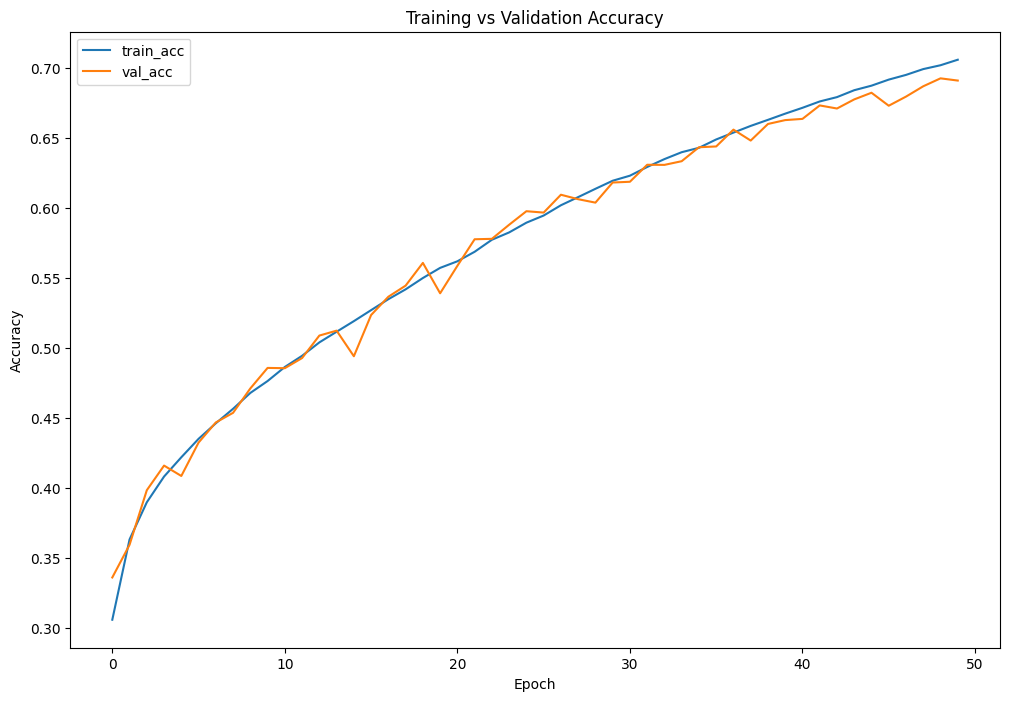

In [49]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(12,8))
plt.plot(boning_history.history['accuracy'], label='train_acc')
plt.plot(boning_history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')

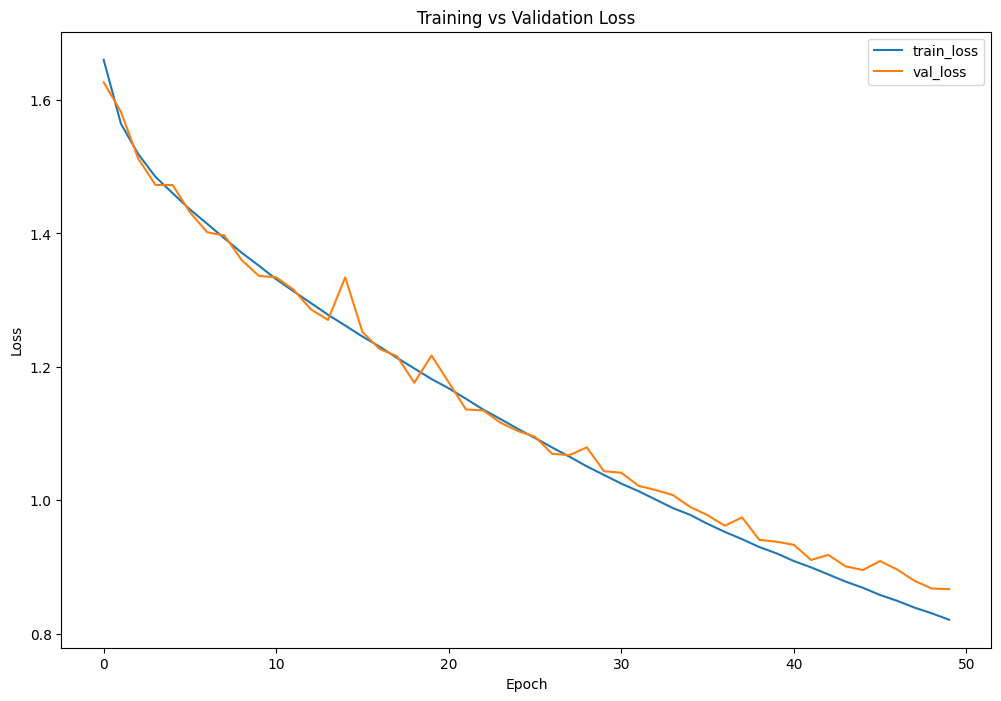

In [50]:
plt.figure(figsize=(12,8))
plt.plot(boning_history.history['loss'], label='train_loss')
plt.plot(boning_history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

In [55]:
boning_y_pred_proba = model.predict(boning_X_test)

2845/2845 ━━━━━━━━━━━━━━━━━━━━ 116s 41ms/step


In [56]:
boning_y_pred = np.argmax(boning_y_pred_proba, axis=1)

In [70]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest')

    tick_marks = np.arange(len(class_names))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(class_names, rotation=90)
    ax.set_yticklabels(class_names)

    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title('Confusion Matrix')

    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('Count')

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha='center', va='center')

    plt.tight_layout()
    plt.show()

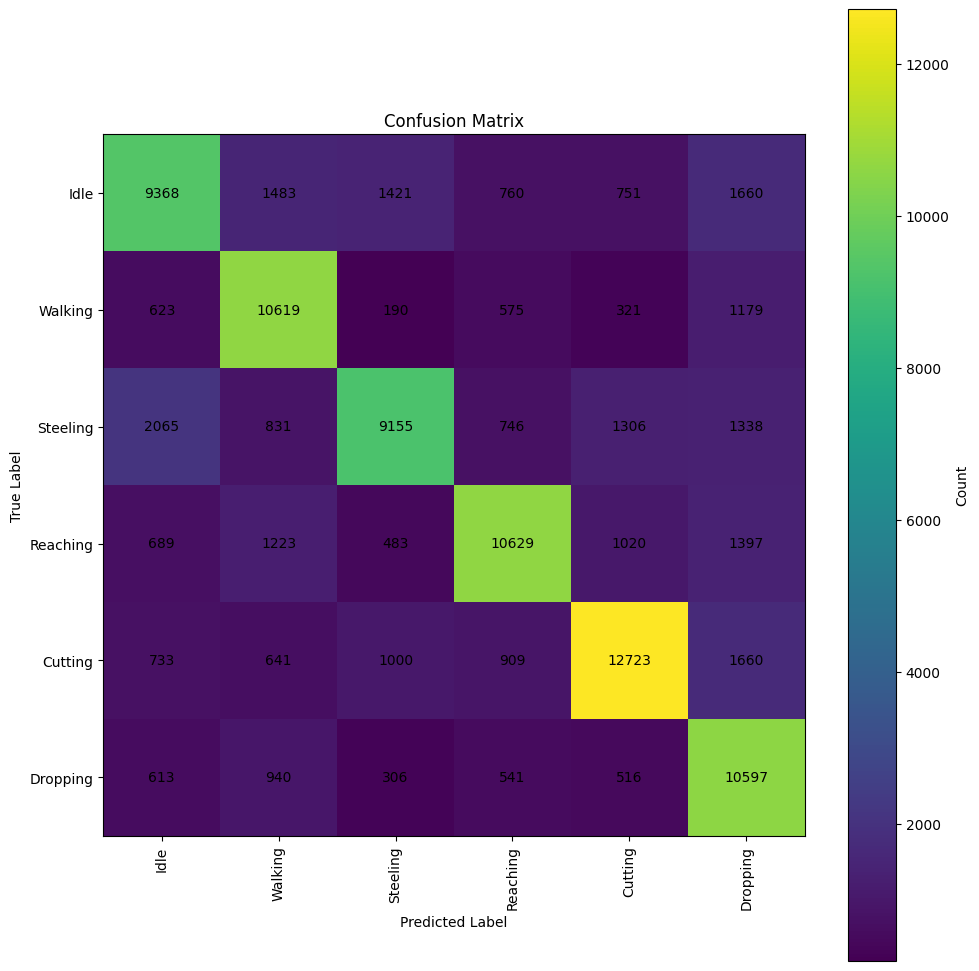

In [71]:
plot_confusion_matrix(boning_y_test, boning_y_pred, boning_activity_class_names)

# **Correlation Analysis grouped by sensor**

In [114]:
from itertools import combinations 

def correlation_analysis(df, threshold: int):
    df_feats = df.drop(columns=['sharpness', 'Label'])
    
    sensors = sorted({col.rsplit('_',1)[0] for col in df_feats.columns})
    
    sensor_cols = {
        sensor: [c for c in df_feats.columns if c.startswith(sensor + '_')]
        for sensor in sensors
    }
    
    sensor_corr = pd.DataFrame(np.eye(len(sensors)), index=sensors, columns=sensors)
    
    for s1, s2 in combinations(sensors, 2):
        max_abs = 0.0
        for c1 in sensor_cols[s1]:
            for c2 in sensor_cols[s2]:
                r = df_feats[c1].corr(df_feats[c2])
                if abs(r) > max_abs:
                    max_abs = abs(r)
    
        sensor_corr.loc[s1, s2] = sensor_corr.loc[s2, s1] = max_abs
    
    threshold = threshold
    to_drop = set()
    for s1, s2 in combinations(sensors, 2):
        if sensor_corr.loc[s1, s2] >= threshold:
            to_drop.add(s2)
    
    print(f"Sensors to drop(corr >= {threshold}): {sorted(to_drop)}")

    cols_to_drop = [c for sensor in to_drop for c in sensor_cols[sensor]]
    print(cols_to_drop)
    df_reduced = df.drop(columns=cols_to_drop)

    return df_reduced

In [115]:
boning_df_reduced_95 = correlation_analysis(boning_df_resampled, threshold=0.95)

Sensors to drop(corr >= 0.95): ['L5', 'Left Toe', 'Right Toe', 'T12']
['T12_mean', 'T12_std', 'T12_min', 'T12_max', 'T12_AUC', 'T12_peaks', 'L5_mean', 'L5_std', 'L5_min', 'L5_max', 'L5_AUC', 'L5_peaks', 'Left Toe_mean', 'Left Toe_std', 'Left Toe_min', 'Left Toe_max', 'Left Toe_AUC', 'Left Toe_peaks', 'Right Toe_mean', 'Right Toe_std', 'Right Toe_min', 'Right Toe_max', 'Right Toe_AUC', 'Right Toe_peaks']


In [144]:
RFM_boning_acc_95, RFM_boning_report_95 = RFM(boning_df_reduced_95)

114
        Left Upper Leg_mean  Left Upper Leg_std  Left Upper Leg_min  \
0                  0.682552            1.868107            1.921719   
1                  1.505051            1.855258            1.910049   
2                  0.400196            0.002230           -0.036756   
3                  1.051740            0.389138            0.603739   
4                  1.656197            1.822196            1.605164   
...                     ...                 ...                 ...   
455046             1.732160            1.066704            1.505240   
455047             0.882356            1.720800            1.782011   
455048             0.193599            0.405005            0.449023   
455049             0.027281           -0.165675           -0.110598   
455050             0.027301            0.811832            0.795901   

        Left Upper Leg_max  Left Upper Leg_AUC  Left Upper Leg_peaks  \
0                 1.677740            0.101988             -0.297216   

In [117]:
boning_df_reduced_90 = correlation_analysis(boning_df_resampled, threshold=0.90)

Sensors to drop(corr >= 0.9): ['L5', 'Left Toe', 'Neck', 'Right Toe', 'T12', 'T8']
['T8_mean', 'T8_std', 'T8_min', 'T8_max', 'T8_AUC', 'T8_peaks', 'Neck_mean', 'Neck_std', 'Neck_min', 'Neck_max', 'Neck_AUC', 'Neck_peaks', 'Left Toe_mean', 'Left Toe_std', 'Left Toe_min', 'Left Toe_max', 'Left Toe_AUC', 'Left Toe_peaks', 'L5_mean', 'L5_std', 'L5_min', 'L5_max', 'L5_AUC', 'L5_peaks', 'Right Toe_mean', 'Right Toe_std', 'Right Toe_min', 'Right Toe_max', 'Right Toe_AUC', 'Right Toe_peaks', 'T12_mean', 'T12_std', 'T12_min', 'T12_max', 'T12_AUC', 'T12_peaks']


In [118]:
RFM_boning_acc_90, RFM_boning_report_90 = RFM(boning_df_reduced_90)

Test accuracy: 99.73%
Confusion Matrix:
[[23152    11     0     0     1     0]
 [   13 20089   157     0     1     0]
 [    2    41 23098    20     1     0]
 [    0     1    18 23141     2     0]
 [    0     2    47    30 26420     0]
 [    0     0     0     0    18 20251]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23164
           1       1.00      0.99      0.99     20260
           2       0.99      1.00      0.99     23162
           3       1.00      1.00      1.00     23162
           4       1.00      1.00      1.00     26499
           5       1.00      1.00      1.00     20269

    accuracy                           1.00    136516
   macro avg       1.00      1.00      1.00    136516
weighted avg       1.00      1.00      1.00    136516

CV accuracies: [0.99834086 0.99778046 0.99817602 0.99870344 0.99820899]
Mean CV accuracy: 99.82%
Std  CV accuracy: 0.03%


In [119]:
boning_df_reduced_85 = correlation_analysis(boning_df_resampled, threshold=0.85)

Sensors to drop(corr >= 0.85): ['L5', 'Left Hand', 'Left Toe', 'Neck', 'Right Hand', 'Right Toe', 'T12', 'T8']
['T8_mean', 'T8_std', 'T8_min', 'T8_max', 'T8_AUC', 'T8_peaks', 'Left Hand_mean', 'Left Hand_std', 'Left Hand_min', 'Left Hand_max', 'Left Hand_AUC', 'Left Hand_peaks', 'Neck_mean', 'Neck_std', 'Neck_min', 'Neck_max', 'Neck_AUC', 'Neck_peaks', 'Left Toe_mean', 'Left Toe_std', 'Left Toe_min', 'Left Toe_max', 'Left Toe_AUC', 'Left Toe_peaks', 'Right Hand_mean', 'Right Hand_std', 'Right Hand_min', 'Right Hand_max', 'Right Hand_AUC', 'Right Hand_peaks', 'L5_mean', 'L5_std', 'L5_min', 'L5_max', 'L5_AUC', 'L5_peaks', 'Right Toe_mean', 'Right Toe_std', 'Right Toe_min', 'Right Toe_max', 'Right Toe_AUC', 'Right Toe_peaks', 'T12_mean', 'T12_std', 'T12_min', 'T12_max', 'T12_AUC', 'T12_peaks']


In [145]:
RFM_boning_acc_85, RFM_boning_report_85 = RFM(boning_df_reduced_85)

90
        Left Upper Leg_mean  Left Upper Leg_std  Left Upper Leg_min  \
0                  0.682552            1.868107            1.921719   
1                  1.505051            1.855258            1.910049   
2                  0.400196            0.002230           -0.036756   
3                  1.051740            0.389138            0.603739   
4                  1.656197            1.822196            1.605164   
...                     ...                 ...                 ...   
455046             1.732160            1.066704            1.505240   
455047             0.882356            1.720800            1.782011   
455048             0.193599            0.405005            0.449023   
455049             0.027281           -0.165675           -0.110598   
455050             0.027301            0.811832            0.795901   

        Left Upper Leg_max  Left Upper Leg_AUC  Left Upper Leg_peaks  \
0                 1.677740            0.101988             -0.297216   


In [125]:
slicing_df_reduced_55 = correlation_analysis(slicing_df_resampled, threshold=0.15)

Sensors to drop(corr >= 0.15): ['L3', 'L5', 'Left Foot', 'Left Forearm', 'Left Hand', 'Left Lower Leg', 'Left Shoulder', 'Left Toe', 'Left Upper Arm', 'Left Upper Leg', 'Neck', 'Pelvis', 'Right Foot', 'Right Forearm', 'Right Hand', 'Right Lower Leg', 'Right Shoulder', 'Right Toe', 'Right Upper Arm', 'Right Upper Leg', 'T12', 'T8']
['Left Upper Leg_mean', 'Left Upper Leg_std', 'Left Upper Leg_min', 'Left Upper Leg_max', 'Left Upper Leg_AUC', 'Left Upper Leg_peaks', 'Left Toe_mean', 'Left Toe_std', 'Left Toe_min', 'Left Toe_max', 'Left Toe_AUC', 'Left Toe_peaks', 'Right Foot_mean', 'Right Foot_std', 'Right Foot_min', 'Right Foot_max', 'Right Foot_AUC', 'Right Foot_peaks', 'Left Forearm_mean', 'Left Forearm_std', 'Left Forearm_min', 'Left Forearm_max', 'Left Forearm_AUC', 'Left Forearm_peaks', 'Left Foot_mean', 'Left Foot_std', 'Left Foot_min', 'Left Foot_max', 'Left Foot_AUC', 'Left Foot_peaks', 'Neck_mean', 'Neck_std', 'Neck_min', 'Neck_max', 'Neck_AUC', 'Neck_peaks', 'Right Hand_mean',

In [143]:
RFM_slicing_acc_55, RFM_slicing_report_55 = RFM(slicing_df_reduced_55)

6
        Head_mean  Head_std  Head_min  Head_max  Head_AUC  Head_peaks
0       -0.390973 -0.402997 -0.286546 -0.382939  0.285267   -1.057572
1       -0.333307 -0.291333 -0.321404 -0.343104  0.816587    0.511420
2        0.665447  0.642300 -0.086499  0.392999  1.053688    0.072685
3       -0.487914 -0.389738 -0.386002 -0.443999 -0.756546    0.293242
4       -0.280744 -0.199732 -0.216369 -0.265945 -0.640554    0.448859
...           ...       ...       ...       ...       ...         ...
647674   0.277978  0.319340  0.571239  0.343876  0.220735    0.549897
647675  -0.240777 -0.275682 -0.229577 -0.281358 -0.646895    0.760812
647676   1.977515  1.538148  0.571890  1.322738 -0.658561    0.425121
647677   0.981080  0.495867  0.754953  0.669021  0.309228   -0.707682
647678   1.269034  1.570940  1.514187  1.346535 -0.474527   -0.212256

[647679 rows x 6 columns] 0         5
1         4
2         4
3         3
4         0
         ..
647674    8
647675    8
647676    8
647677    8
647678    8

In [127]:
slicing_df_reduced_55.head()

,Head_mean,Head_std,Head_min,Head_max,Head_AUC,Head_peaks,Label,sharpness
0,-0.390973,-0.402997,-0.286546,-0.382939,0.285267,-1.057572,5,90
1,-0.333307,-0.291333,-0.321404,-0.343104,0.816587,0.511420,4,90
2,0.665447,0.642300,-0.086499,0.392999,1.053688,0.072685,4,90
3,-0.487914,-0.389738,-0.386002,-0.443999,-0.756546,0.293242,3,87
4,-0.280744,-0.199732,-0.216369,-0.265945,-0.640554,0.448859,0,73


7